In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from PIL import Image
from mtcnn.mtcnn import MTCNN
from numpy import asarray
import cv2
import matplotlib.pyplot as plt

In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 14.2 MB/s 


In [ ]:
#%% Define some params
DATA_PATH_INFERENCE = "/content/drive/MyDrive/CS512-Computer Vision/Project/Inference_Dataset"
MODEL_PATH = '/content/drive/MyDrive/CS512-Computer Vision/Project/Weights'
MODEL_NAME = 'siam-face-recognition.h5'

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)

  # convert to RGB, if needed
	image = image.convert('RGB')

  # convert to array
	pixels = asarray(image)

  # create the detector, using default weights
	detector = MTCNN()

  # detect faces in the image
	results = detector.detect_faces(pixels)

  # extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']

  # bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height

  # extract the face
	face = pixels[y1:y2, x1:x2]

  # resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)

	return face_array

In [ ]:
def visualize_sample_face(path_to_actual, path_to_predicted):
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    actual_img = cv2.imread(path_to_actual, 1)
    pred_img = cv2.imread(path_to_predicted, 1)

    ax1.imshow(actual_img)
    ax2.imshow(pred_img)

    ax1.set_title('Actual')
    ax1.axis('off')
    ax2.set_title('Predicted')
    ax2.axis('off')

In [ ]:
print(os.path.join(MODEL_PATH, MODEL_NAME))

/content/drive/MyDrive/CS512-Computer Vision/Project/Weights/siam-face-recognition.h5


In [ ]:
model = load_model(os.path.join(MODEL_PATH, MODEL_NAME),
                   custom_objects={'contrastive_loss': contrastive_loss})

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 50)           106850      ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
img_w, img_h = 160, 160

### Predict with the randomly selected image

##### Randomly select one person and then one image for that person

In [ ]:

pathlist = os.listdir(DATA_PATH_INFERENCE)
category = pathlist[np.random.randint(len(pathlist))]
cur_path = os.path.join(DATA_PATH_INFERENCE, category)
filelist = os.listdir(cur_path)
file_name = filelist[np.random.randint(len(filelist))]
path_to_ref_image = os.path.join(cur_path, file_name)
path_to_ref_image_copy = str(path_to_ref_image)
pixels = extract_face(path_to_ref_image)
ref_img = Image.fromarray(pixels, mode='RGB')
ref_img = np.array(ref_img)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_RGB2BGR)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)
ref_img = cv2.resize(ref_img, (img_w, img_h))
ref_img_copy = ref_img.copy()
ref_img = np.array(ref_img, dtype = np.float64)
ref_img /= 255
ref_img = ref_img[..., np.newaxis]


##### Iterate through images of each person and calculate the distance between reference image and current image

In [ ]:
results = []
pathlist_all = os.listdir(DATA_PATH_INFERENCE)
for cat in range(len(pathlist_all)):
    cur_cat  = pathlist_all[cat]
    cur_path = os.path.join(DATA_PATH_INFERENCE, cur_cat)
    filelist = os.listdir(cur_path)
    file_name = filelist[np.random.randint(len(filelist))]
    path_to_cur_image = os.path.join(cur_path, file_name)
    path_to_cur_image_copy = str(path_to_cur_image)
    pixels = extract_face(path_to_cur_image)
    cur_img = Image.fromarray(pixels, mode='RGB')
    cur_img = np.array(cur_img)
    cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2BGR)
    cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2GRAY)
    cur_img = cv2.resize(cur_img, (img_w, img_h))
    cur_img = np.array(cur_img, dtype = np.float64)
    cur_img /= 255
    cur_img = cur_img[..., np.newaxis] 
    pairs=[np.zeros((1, img_h, img_w, 1)) for i in range(2)]
    pairs[0][0, :, :, :] = ref_img
    pairs[1][0, :, :, :] = cur_img
    dist = model.predict([pairs[0], pairs[1]])[0][0]
    results.append((cur_cat,dist,path_to_cur_image))
   

results.sort(key = lambda x : x[1])

##### Select the image with smallest distance from reference image 

In [ ]:
print("Actual Category: %s" % category)
print("Predicted Category: %s" % results[0][0])

Actual Category: Saurav
Predicted Category: Saurav


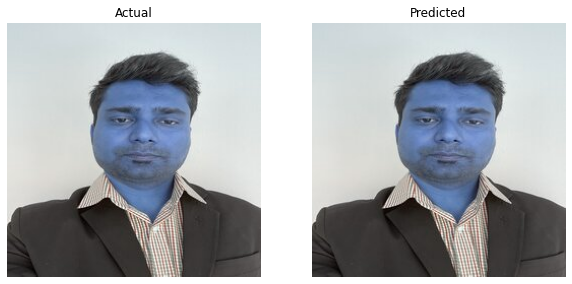

In [ ]:
visualize_sample_face(path_to_ref_image_copy, results[0][2])